<a href="https://colab.research.google.com/github/AXBOUF/python_visulization/blob/main/nyctaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MESSED UP BIG TIME

# USING PYSPARK FINALLY

In [41]:
!pip install pyspark

In [71]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('nyc_trip_predict').getOrCreate()
data_trip=spark.read.csv('nyc_taxi_trip_duration.csv', header=True, inferSchema=True)
data_trip.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



In [74]:
spark

spark did good job recognizing the datatype of different features even tho lets peek the head of data

In [72]:
# lets try stick with spark syntax and use less of
data_trip.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id1080784|        2|2016-02-29 16:40:21|2016-02-29 16:47:01|              1|-73.95391845703125| 40.77887344360352|-73.96387481689453| 40.77116394042969|                 N|          400|
|id0889885|        1|2016-03-11 23:35:37|2016-03-11 23:53:57|              2|-73.98831176757811| 40.73174285888672| -73.9947509765625| 40.69493103027344|                 N|         1100|
|id0857912|        2|2016-02-21 17:59:33|2016-02-21 18:26:48|    

General walkthrough

id - unique trip id, vendor_id - 1,2 , pickup_datetime, dropoff_datetime (yyyy-mm-dd hh:mm:ss ), passenger_count number of passenger in a trip, pickup_longitude and latitude pin points the pickup location similarly dropoff gives the drop off location.

store_and_fwd_flag - no idea for now, trip_duration is our dependent variable which we will attempt to predict by using rest of independent variables.




# DATA PREPROCESSING

In [44]:
data_trip.describe().show()

+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|    pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|
+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|  count|   729322|            729322|            729322|             729322|             729322|             729322|             729322|            729322|            729322|
|   mean|     NULL|1.5354027439183242|1.6620546205928246| -73.97351307454848|  40.75091887972495| -73.97342219209891| 40.751775436975464|              NULL| 952.2291333594764|
| stddev|     NULL|0.4987454128000744|1.3124456158621784|0.06975384025050611|0.03359412072122873|0.06958815677984773|0.0

## count is consistent among all the variables that a good sight (729322)

In [50]:
from pyspark.sql import functions as F

data_trip.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data_trip.columns]).show()


+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



#### thats a good sign that dataset holds no null values thank you !!

Interesting findings on passenger_count and trip_duration lets see that up close

In [47]:
# lets see only one feature description
data_trip.select('passenger_count','trip_duration').describe().show()

+-------+------------------+------------------+
|summary|   passenger_count|     trip_duration|
+-------+------------------+------------------+
|  count|            729322|            729322|
|   mean|1.6620546205928246| 952.2291333594764|
| stddev|1.3124456158621784|3864.6261972812454|
|    min|                 0|                 1|
|    max|                 9|           1939736|
+-------+------------------+------------------+



Call me insane but a trip 1939736 sec ~ 538.8155556 hours is an absolute outliers similarly trip lasting 1 sec too.

On other hand passenger_count 0, 9 could be possible considering a van trip or supposedly a larger SUV but we will see how many are there and conclude if it is an outlier or not. Potentially it maybe an outlier.  

lets see the count of vendor_id to see if the dataset consists of balanced data from both vendor and we will also later conclude of vendor id plays any significane when it comes to data trip duration or not

In [57]:
# lets see the count of vendor_id to see if the dataset consists of balanced data from both vendor
vendor_spread = data_trip.groupBy('vendor_id').count()

In [58]:
pdf = vendor_spread.toPandas()

In [61]:
# i will try to use same color palette to refer to vendor id 1 and vendor id 2
my_palette = ["#77B7A8", "#E09E7E"]

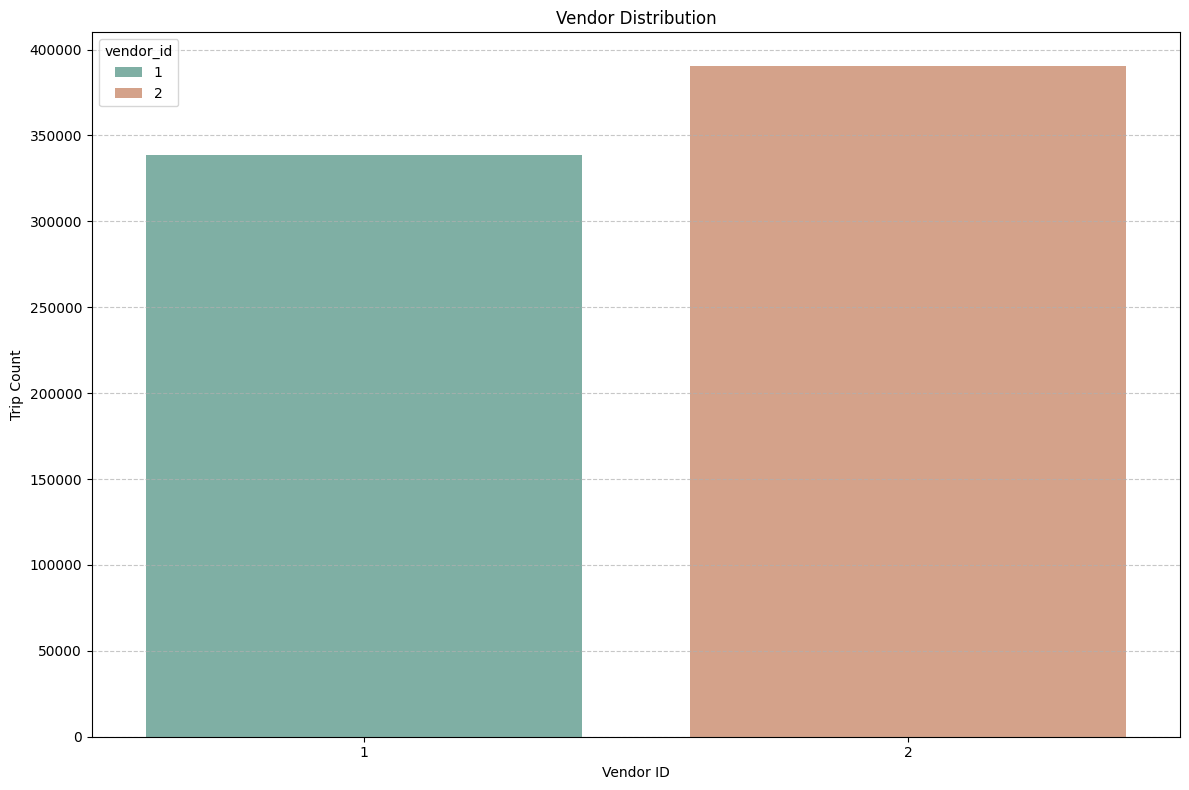

In [64]:
import seaborn as sns


plt.figure(figsize=(12,8))
ax = sns.barplot(data=pdf,x="vendor_id",y="count",hue="vendor_id",palette=my_palette)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Vendor Distribution")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Count")
plt.tight_layout()
plt.show()

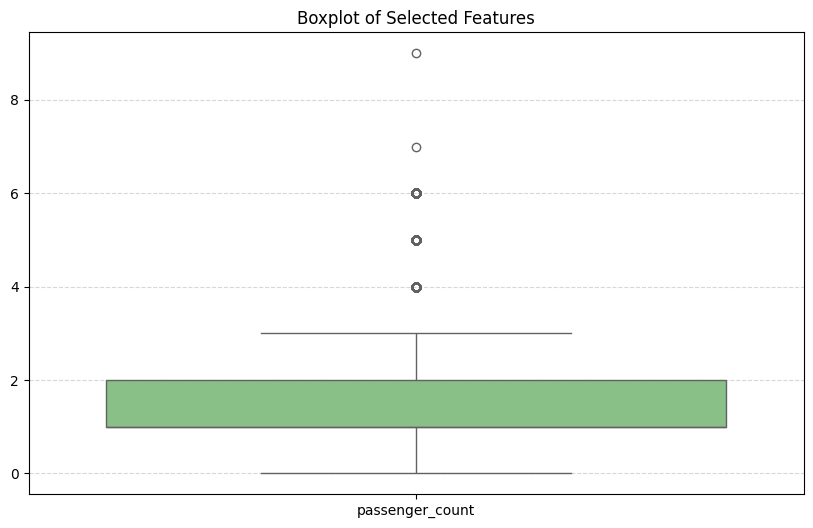

In [128]:
# lets see now the boxplot of passenger_count to address if there are any outlier
features = ["passenger_count"]
pdf = data_trip.select(*features).toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf, palette='Accent') # other color paletter recommendation ~ Set2, Set1, tab10, Accent, crest, rocket.
plt.title("Boxplot of Selected Features")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

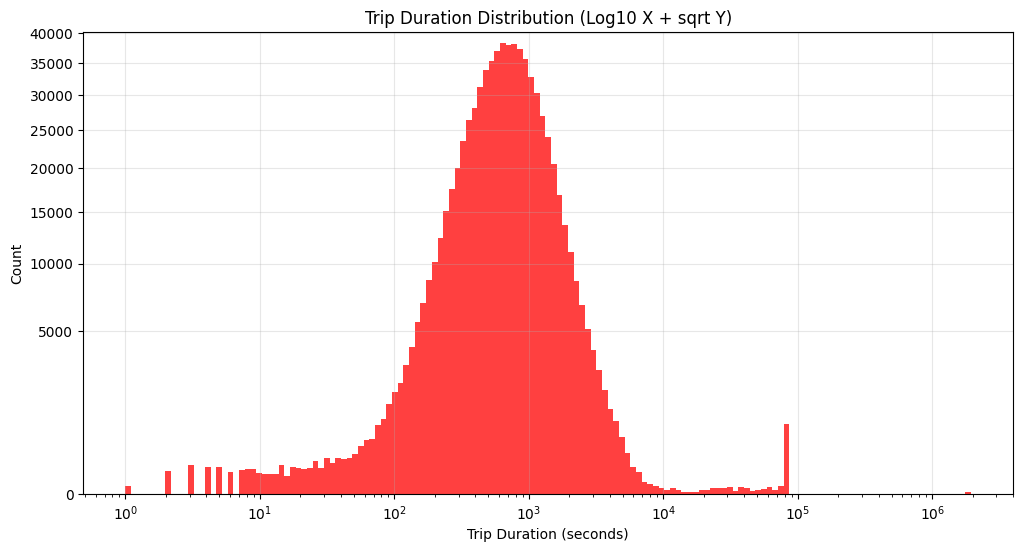

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale
pdf = data_trip.select("trip_duration").toPandas()

plt.figure(figsize=(12, 6))

# histogram with log-spaced bins (CRITICAL PART)
bins = np.logspace(
    np.log10(pdf["trip_duration"].min()),
    np.log10(pdf["trip_duration"].max()),
    150
)

sns.histplot(pdf["trip_duration"], bins=bins, color="red")

# log-scale x axis
plt.xscale("log")

# sqrt y scale (ggplot equivalent)
plt.yscale('function', functions=(np.sqrt, lambda y: y**2))

plt.title("Trip Duration Distribution (Log10 X + sqrt Y)")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.grid(alpha=0.3)

plt.show()


Most trips look kind of log-normal with a big peak just under 1000 seconds (around 15–20 minutes). There are a bunch of weird super-short trips under 10 seconds, which are probably data errors. There’s also a sharp spike right before 1e5 seconds and a few trips way beyond that, meaning there are some extreme outliers where the trip duration is recorded in hours or even days.

In [103]:
pdf['trip_duration'].describe()

count    729322.0000
mean        952.2291
std        3864.6262
min           1.0000
25%         397.0000
50%         663.0000
75%        1075.0000
max     1939736.0000
Name: trip_duration, dtype: float64

# lets peek the duration of dataset we have for the trip since when its recored

In [104]:
import pyspark.sql.functions as F

data_trip.agg(
    F.min("pickup_datetime").alias("start"),
    F.max("pickup_datetime").alias("end")
).show()

+-------------------+-------------------+
|              start|                end|
+-------------------+-------------------+
|2016-01-01 00:01:14|2016-06-30 23:59:37|
+-------------------+-------------------+



1ST OF JANUARY 2016 - 30TH OF JUNE 2016.

This gives us an idea of start and end of recorded trip data in the whole dataset

In [108]:
import pyspark.sql.functions as F

data_trip = data_trip.withColumn(
    "pickup_ym",
    F.date_format("pickup_datetime", "yyyy-MM")
)


In [109]:
monthly = (
    data_trip.groupBy("pickup_ym")
             .count()
             .orderBy("pickup_ym")
)


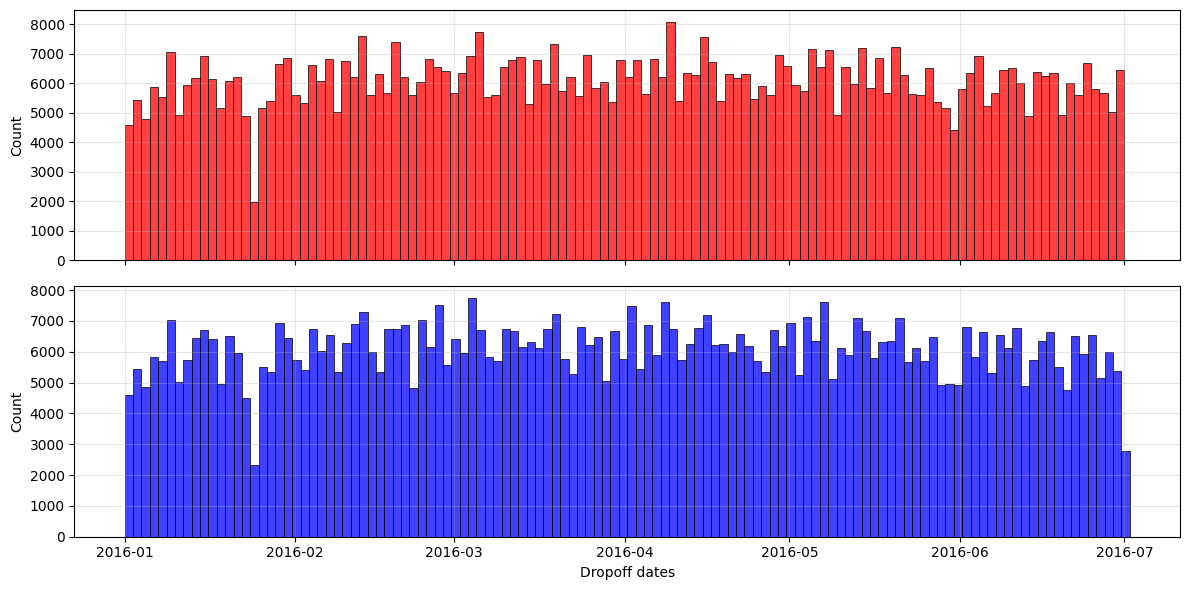

In [112]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Convert columns to pandas first
pdf = data_trip.select("pickup_datetime", "dropoff_datetime").toPandas()

# Pickup histogram
sns.histplot(pdf["pickup_datetime"], bins=120, color="red", ax=axes[0])
axes[0].set_xlabel("Pickup dates")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# Dropoff histogram
sns.histplot(pdf["dropoff_datetime"], bins=120, color="blue", ax=axes[1])
axes[1].set_xlabel("Dropoff dates")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



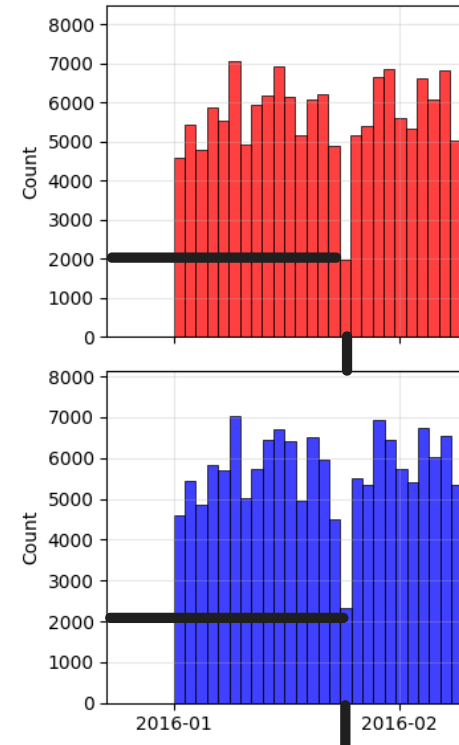

Closer look tell the lowest recorded near end of January with count approx 2000, which could be due to many factor weather, event, shutdown....

# lets check the consistency if pickup - dropoff equals trip_duration

In [114]:
import pyspark.sql.functions as F

data_trip = (
    data_trip
    # pickup
    .withColumn("pickup_date",     F.to_date("pickup_datetime"))
    .withColumn("pickup_year",     F.year("pickup_datetime"))
    .withColumn("pickup_month",    F.month("pickup_datetime"))
    .withColumn("pickup_day",      F.dayofmonth("pickup_datetime"))
    .withColumn("pickup_hour",     F.hour("pickup_datetime"))
    .withColumn("pickup_minute",   F.minute("pickup_datetime"))
    .withColumn("pickup_weekday",  F.dayofweek("pickup_datetime"))  # 1 = Sunday

    # dropoff
    .withColumn("dropoff_date",     F.to_date("dropoff_datetime"))
    .withColumn("dropoff_year",     F.year("dropoff_datetime"))
    .withColumn("dropoff_month",    F.month("dropoff_datetime"))
    .withColumn("dropoff_day",      F.dayofmonth("dropoff_datetime"))
    .withColumn("dropoff_hour",     F.hour("dropoff_datetime"))
    .withColumn("dropoff_minute",   F.minute("dropoff_datetime"))
    .withColumn("dropoff_weekday",  F.dayofweek("dropoff_datetime"))
)


breaking down both pickup and dropoff datetimes into granular features (year, month, day, hour, minute, weekday) so I don’t have to repeatedly strip time components later. This makes grouping, plotting, and analysing time-based patterns much easier and faster throughout the notebook.

In [118]:
weekday_vendor = (
    data_trip.groupBy("pickup_weekday", "vendor_id")
             .count()
             .orderBy("pickup_weekday", "vendor_id")
)


In [119]:
pdf_wv = weekday_vendor.toPandas()


In [120]:
weekday_map = {
    1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed",
    5: "Thu", 6: "Fri", 7: "Sat"
}

pdf_wv["weekday"] = pdf_wv["pickup_weekday"].map(weekday_map)


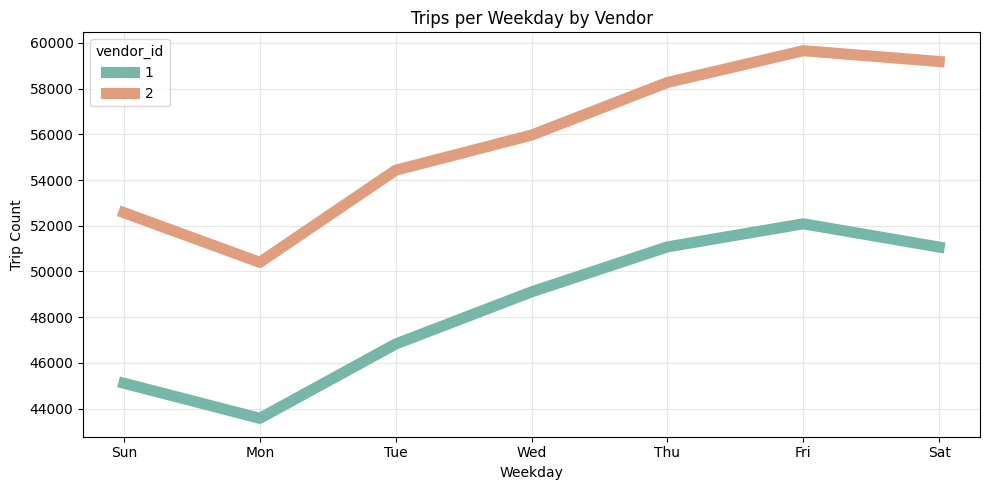

In [141]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=pdf_wv,
    x="weekday",
    y="count",
    hue="vendor_id",
    markers=True,
    palette=my_palette,
    linewidth= 8
)

plt.title("Trips per Weekday by Vendor")
plt.xlabel("Weekday")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Interesting finding , both vendors follow the same weekday pattern: slowest on sunday and monday, then trips gradually climb.

Vendor 2 has consistenly more rides than vendor 1 also the shape is somehow identical for both.

### Lets see spread in hours of the day

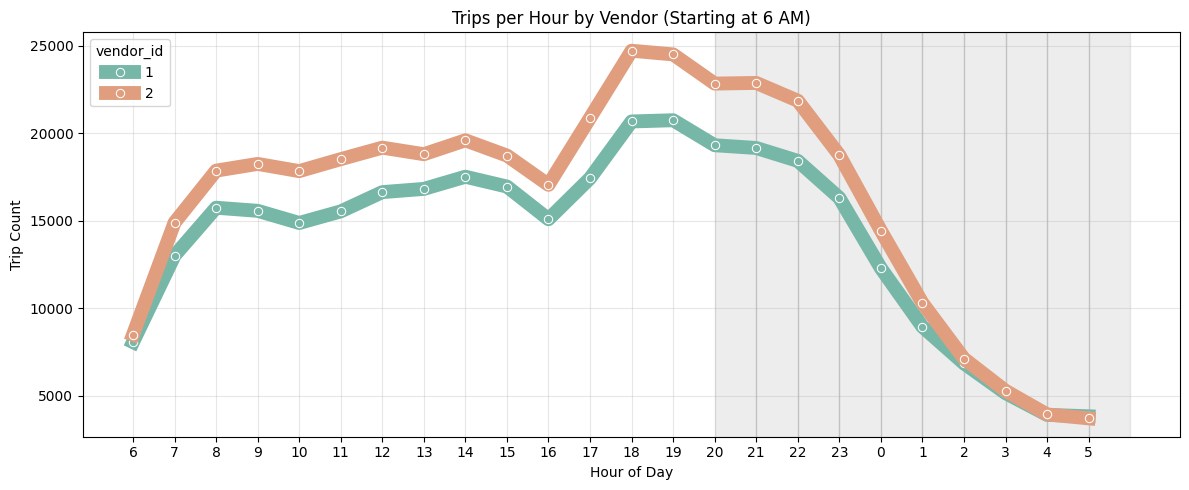

In [140]:
hour_vendor = (
    data_trip.groupBy("pickup_hour", "vendor_id")
             .count()
             .orderBy("pickup_hour", "vendor_id")
)

pdf_hv = hour_vendor.toPandas()

# rotate hours so the plot starts at 6 AM
pdf_hv["rot_hour"] = (pdf_hv["pickup_hour"] - 6) % 24

# sort by the rotated hour
pdf_hv = pdf_hv.sort_values("rot_hour")

plt.figure(figsize=(12,5))

sns.lineplot(
    data=pdf_hv,
    x="rot_hour",
    y="count",
    hue="vendor_id",
    marker="o",
    palette=my_palette,
    linewidth= 10
)

plt.title("Trips per Hour by Vendor (Starting at 6 AM)")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)

# night shading for real hours (20–23 and 0–5)
night_hours = list(range(20, 24)) + list(range(0, 6))

for h in night_hours:
    plt.axvspan((h-6)%24, (h-6)%24 + 1, color="black", alpha=0.07)

# x-axis labels should show REAL hours
plt.xticks(
    ticks=range(24),
    labels=[(h + 6) % 24 for h in range(24)]
)

plt.tight_layout()
plt.show()


If we plot the line starting from 6am we can see a clear pattern of trips starting same at 6 am between both vendor then the vendor 2 trip count goes up following the general count of both vendor peaking during late evening then line goes steep down from midnight.


Overview people are taking taxi generally during day with peak demand during late evening and steep low demand after midnight with lowest count early morning 5am

/tmp/ipython-input-3331461287.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pass_count, x="passenger_count", y="count", palette="Pastel1")


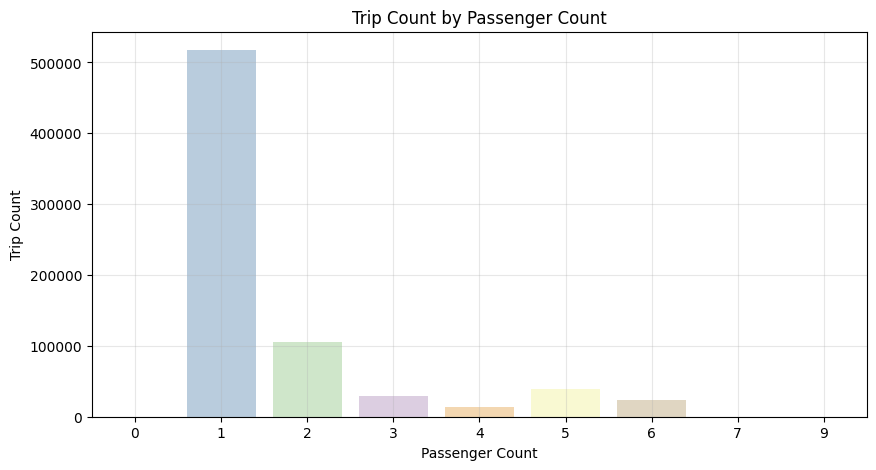

In [131]:
# lets visualize passenger_count
passenger_count = (
    data_trip.groupBy("passenger_count")
             .count()
             .orderBy("passenger_count")
)

pass_count = passenger_count.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=pass_count, x="passenger_count", y="count", palette="Pastel1")
plt.title("Trip Count by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)
plt.show()

### Most of the passenger count is 1 which tells most taxi trips are for single person

In [132]:
month_labels = {
    1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
    7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"
}

weekday_labels = {
    1:"Sun",2:"Mon",3:"Tue",4:"Wed",5:"Thu",6:"Fri",7:"Sat"
}
hour_month = (
    data_trip.groupBy("pickup_hour", "pickup_month")
             .count()
             .orderBy("pickup_hour", "pickup_month")
)

pdf_hm = hour_month.toPandas()
pdf_hm["Month"] = pdf_hm["pickup_month"].map(month_labels)


In [133]:
hour_weekday = (
    data_trip.groupBy("pickup_hour", "pickup_weekday")
             .count()
             .orderBy("pickup_hour", "pickup_weekday")
)

pdf_hw = hour_weekday.toPandas()
pdf_hw["Wday"] = pdf_hw["pickup_weekday"].map(weekday_labels)


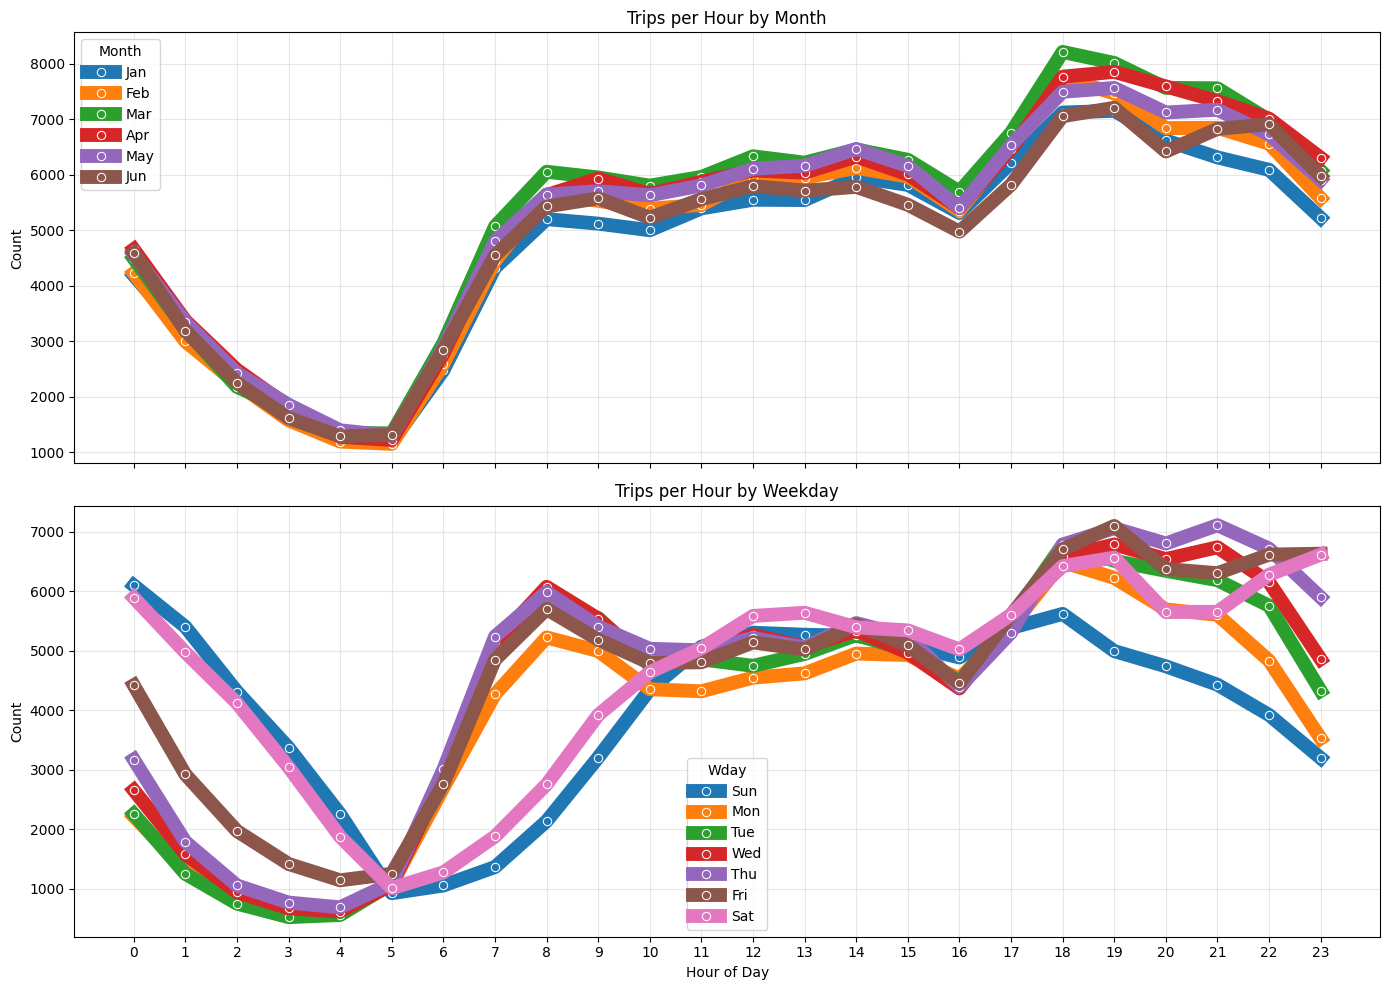

In [139]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# p1 — hour × month
sns.lineplot(
    data=pdf_hm,
    x="pickup_hour",
    y="count",
    hue="Month",
    ax=axes[0],
    marker="o",
    linewidth=10 # more width helps visualize the dominance line
)
axes[0].set_title("Trips per Hour by Month")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# p2 — hour × weekday
sns.lineplot(
    data=pdf_hw,
    x="pickup_hour",
    y="count",
    hue="Wday",
    ax=axes[1],
    marker="o",
    linewidth=10
)
axes[1].set_title("Trips per Hour by Weekday")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


January and June seem to have fewer trips overall, while March and April stand out as the busier months. Both vendors follow this same general pattern, so it looks like a dataset-wide trend rather than something vendor-specific.

The weekend behaviour is noticeably different from the weekday flow. Late-night and early-morning hours (especially Friday and Saturday) see more activity, which lines up with typical NYC nightlife. But from around 5 AM to 10 AM, trip counts dip on weekends compared to weekdays because there’s no morning commute. There’s also a clear drop-off on Sunday evening as the weekend wraps up.

## “Added a thicker line width so the dominant trends stand out more clearly and are easier to compare across months and weekdays.”

## latitude longitude

In [145]:
MIN_LON, MAX_LON = -74.05, -73.70
MIN_LAT, MAX_LAT = 40.60, 40.90


In [146]:
filtered = (
    data_trip
    .filter((F.col("pickup_longitude") > MIN_LON) & (F.col("pickup_longitude") < MAX_LON))
    .filter((F.col("dropoff_longitude") > MIN_LON) & (F.col("dropoff_longitude") < MAX_LON))
    .filter((F.col("pickup_latitude") > MIN_LAT) & (F.col("pickup_latitude") < MAX_LAT))
    .filter((F.col("dropoff_latitude") > MIN_LAT) & (F.col("dropoff_latitude") < MAX_LAT))
)


In [147]:
pdf_f = filtered.select(
    "pickup_longitude", "dropoff_longitude",
    "pickup_latitude", "dropoff_latitude"
).toPandas()


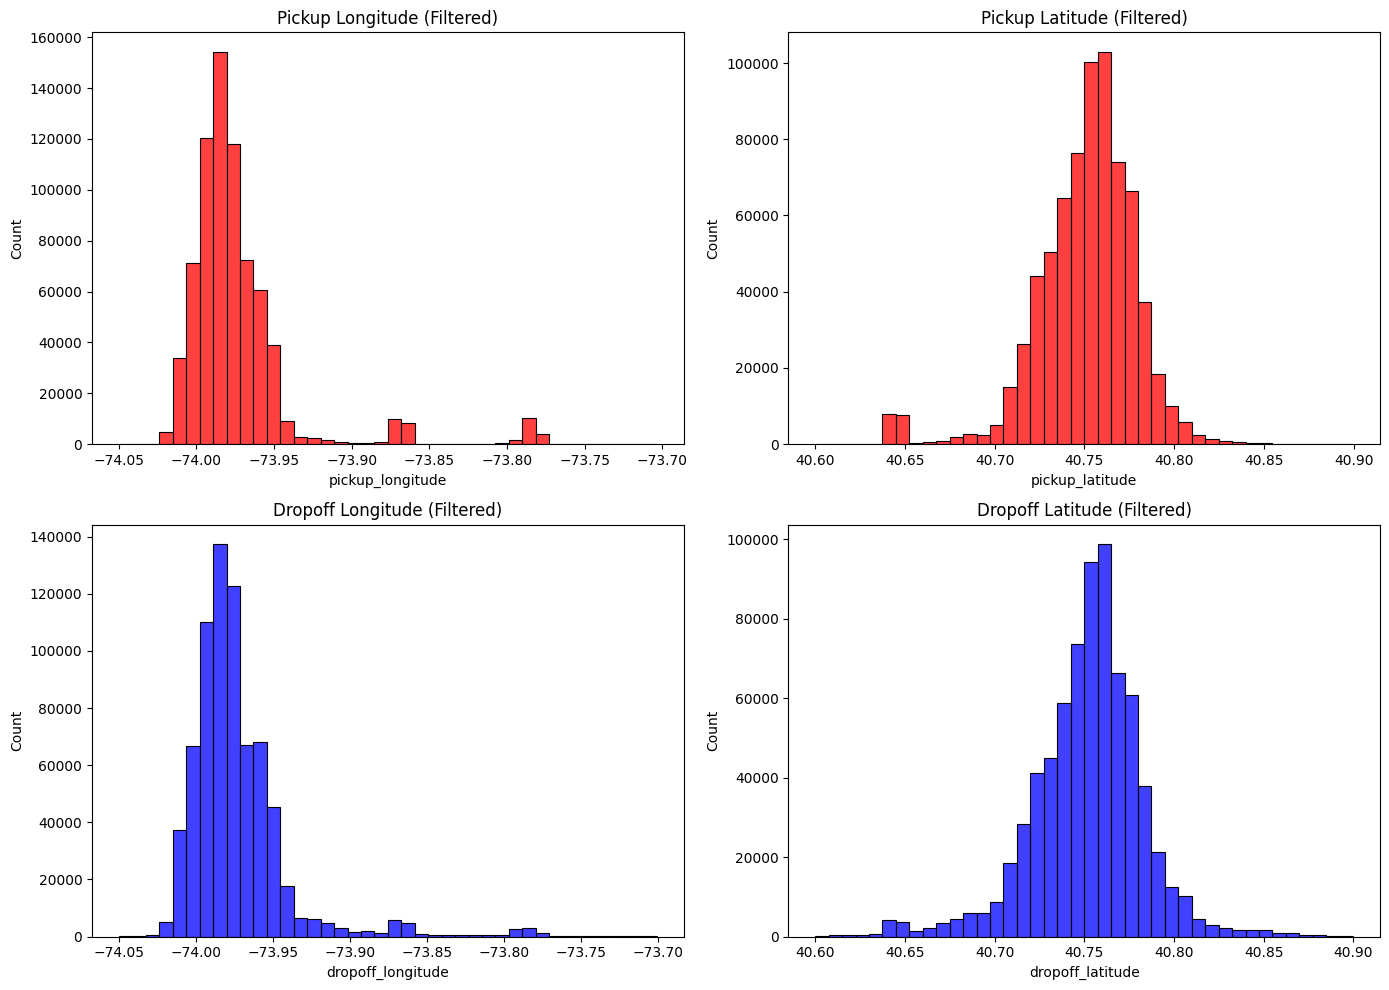

In [150]:
plt.figure(figsize=(14, 10))

# pickup longitude
plt.subplot(2, 2, 1) # the last number refers to the position in the plot
sns.histplot(pdf_f["pickup_longitude"], bins=40, color="red")
plt.title("Pickup Longitude (Filtered)")

# pickup latitude
plt.subplot(2, 2, 2)
sns.histplot(pdf_f["pickup_latitude"], bins=40, color="red")
plt.title("Pickup Latitude (Filtered)")

# dropoff longitude
plt.subplot(2, 2, 3)
sns.histplot(pdf_f["dropoff_longitude"], bins=40, color="blue")
plt.title("Dropoff Longitude (Filtered)")



# dropoff latitude
plt.subplot(2, 2, 4)
sns.histplot(pdf_f["dropoff_latitude"], bins=40, color="blue")
plt.title("Dropoff Latitude (Filtered)")

plt.tight_layout()
plt.show()


We constrained the latitude and longitude ranges because a handful of trips had coordinates far outside NYC, which would distort the histograms. After filtering to a reasonable NYC bounding box, the location distributions line up with what we saw on the map earlier — most activity is concentrated around Manhattan, with the expected spread into nearby boroughs.

### We’re not cleaning the data yet — this filter is just for exploration so the plots make sense. The actual dataset cleaning will happen later in the proper preprocessing phase.

# Feature relations

trip_duration vs trip_distance


trip_duration vs time-of-day (already doing this)

trip_duration vs passenger_count


trip_duration vs vendor_id


trip_duration vs pickup_lat/long


In [151]:
weekday_vendor = (
    data_trip.groupBy("pickup_weekday", "vendor_id")
             .agg(F.expr("percentile_approx(trip_duration, 0.5)").alias("median_trip"))
)

pdf_wv = weekday_vendor.toPandas()

# convert seconds → minutes
pdf_wv["median_minutes"] = pdf_wv["median_trip"] / 60

# weekday labels (R uses Monday as start)
weekday_labels = {1:"Sun", 2:"Mon", 3:"Tue", 4:"Wed", 5:"Thu", 6:"Fri", 7:"Sat"}
pdf_wv["weekday"] = pdf_wv["pickup_weekday"].map(weekday_labels)

# keep weekday order
order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
pdf_wv["weekday"] = pd.Categorical(pdf_wv["weekday"], categories=order, ordered=True)


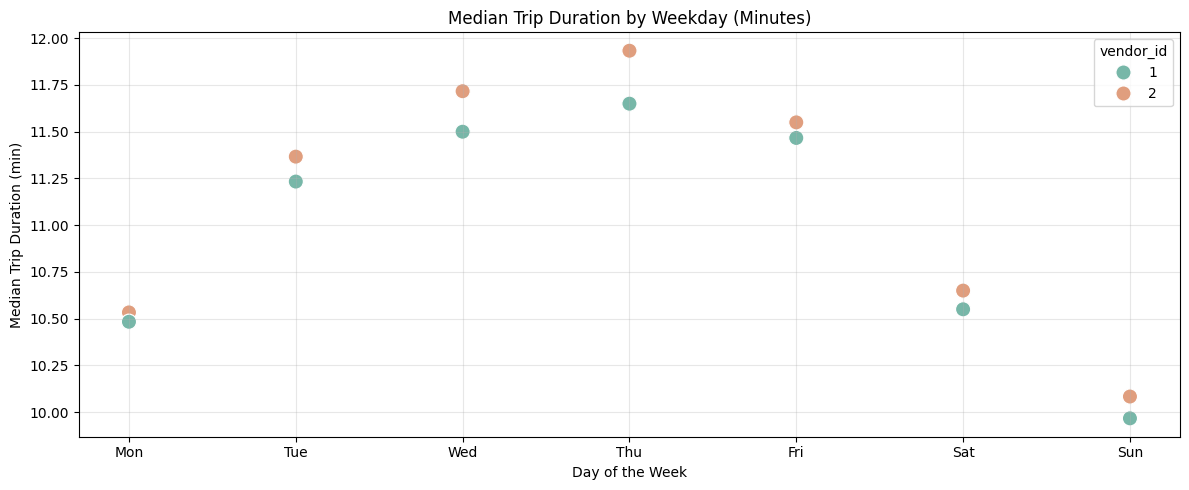

In [153]:
plt.figure(figsize=(12,5))

sns.scatterplot(
    data=pdf_wv,
    x="weekday",
    y="median_minutes",
    hue="vendor_id",
    s=120,
    palette=my_palette,
)

plt.title("Median Trip Duration by Weekday (Minutes)")
plt.xlabel("Day of the Week")
plt.ylabel("Median Trip Duration (min)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


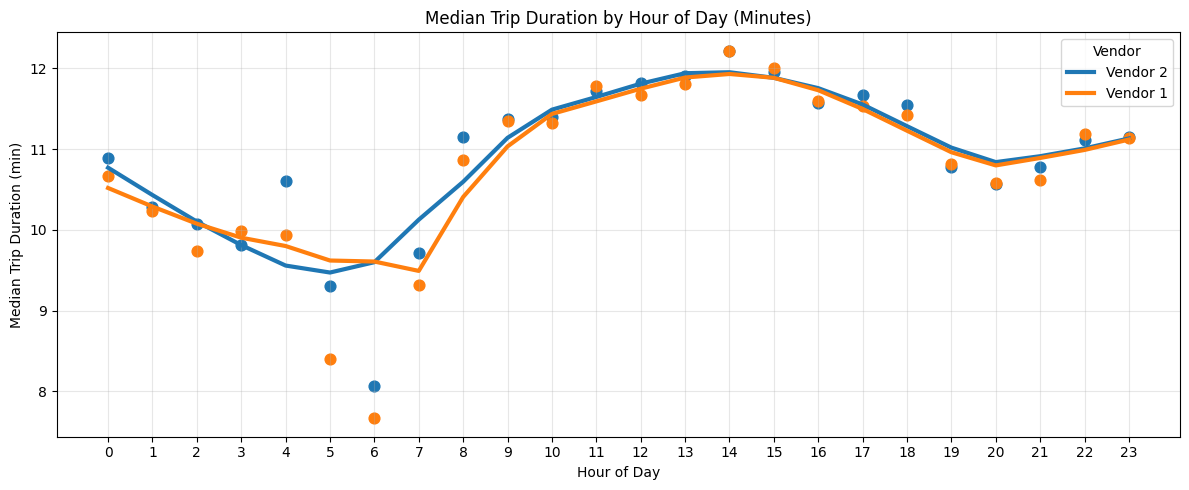

In [154]:
hour_vendor = (
    data_trip.groupBy("pickup_hour", "vendor_id")
             .agg(F.expr("percentile_approx(trip_duration, 0.5)").alias("median_trip"))
)

pdf_hv = hour_vendor.toPandas()

# seconds → minutes
pdf_hv["median_minutes"] = pdf_hv["median_trip"] / 60
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(12,5))

for vid in pdf_hv["vendor_id"].unique():
    subset = pdf_hv[pdf_hv["vendor_id"] == vid]

    # smoothing (similar to R's geom_smooth(method="loess"))
    smoothed = lowess(subset["median_minutes"], subset["pickup_hour"], frac=0.3)

    plt.plot(smoothed[:,0], smoothed[:,1], linewidth=3, label=f"Vendor {vid}")
    plt.scatter(subset["pickup_hour"], subset["median_minutes"], s=60)

plt.title("Median Trip Duration by Hour of Day (Minutes)")
plt.xlabel("Hour of Day")
plt.ylabel("Median Trip Duration (min)")
plt.grid(alpha=0.3)
plt.legend(title="Vendor")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


Both vendors display the same temporal pattern in trip duration — peaking in the early afternoon and dipping early in the morning. Weekdays tend to have slightly longer median trip durations than weekends, with Sunday being the quietest. This suggests that traffic conditions (time-of-day, day-of-week) drive trip duration much more than the vendor itself.

In [168]:
pdf = data_trip.select("trip_duration", "passenger_count").toPandas()
pdf["duration_min"] = pdf["trip_duration"] / 60


/tmp/ipython-input-2020188718.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


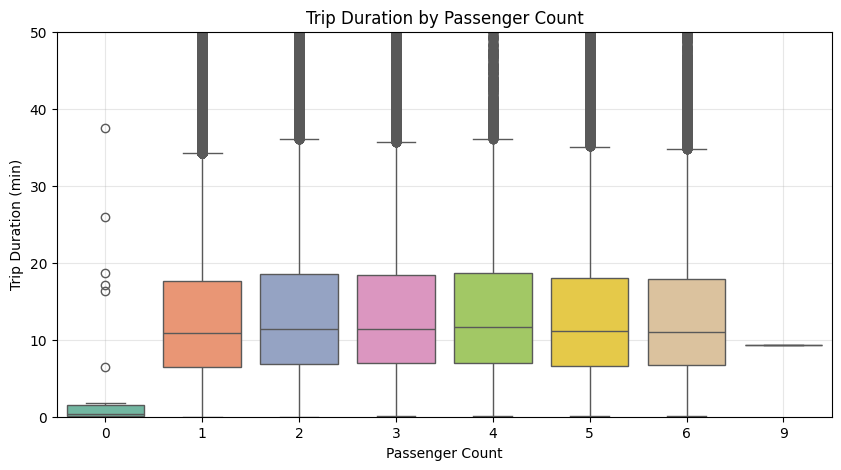

In [169]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=pdf,
    x="passenger_count",
    y="duration_min",
    palette="Set2"
)
plt.ylim(0, 50)   # optional: limit to 50 min to avoid extreme outliers
plt.title("Trip Duration by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


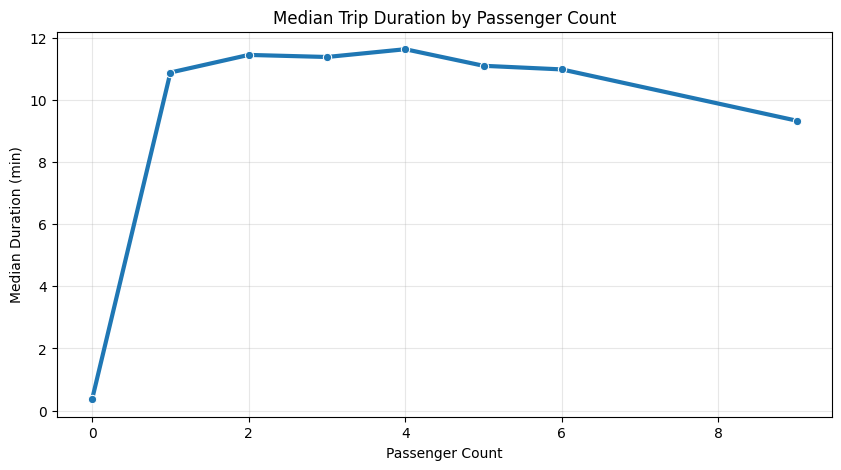

In [170]:
pdf_med = pdf.groupby("passenger_count")["duration_min"].median().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=pdf_med,
    x="passenger_count",
    y="duration_min",
    marker="o",
    linewidth=3,
)
plt.title("Median Trip Duration by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Median Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-310969441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


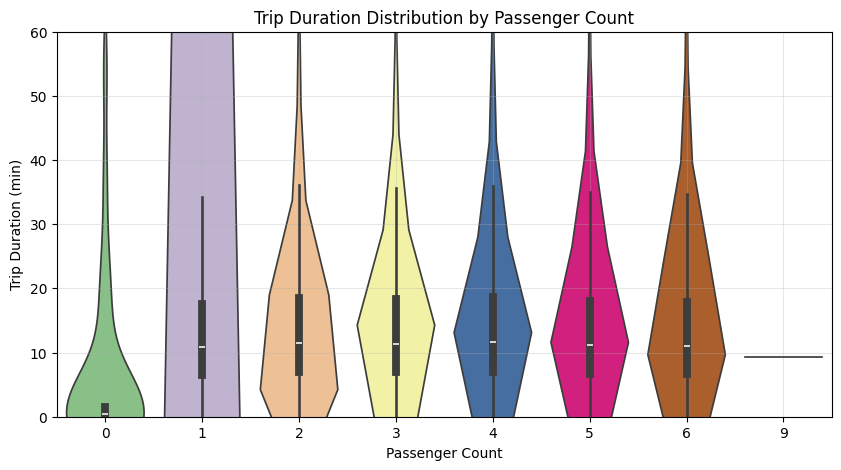

In [171]:
plt.figure(figsize=(10,5))
sns.violinplot(
    data=pdf,
    x="passenger_count",
    y="duration_min",
    palette="Accent"
)
plt.ylim(0, 60)
plt.title("Trip Duration Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-332005335.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


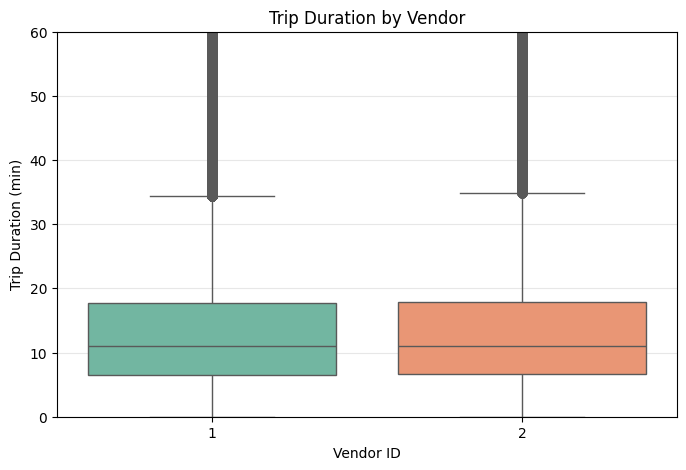

In [172]:
pdf = data_trip.select("vendor_id", "trip_duration").toPandas()
pdf["duration_min"] = pdf["trip_duration"] / 60
plt.figure(figsize=(8,5))
sns.boxplot(
    data=pdf,
    x="vendor_id",
    y="duration_min",
    palette="Set2"
)

plt.ylim(0, 60)  # optional to hide insane outliers
plt.title("Trip Duration by Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-884487585.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


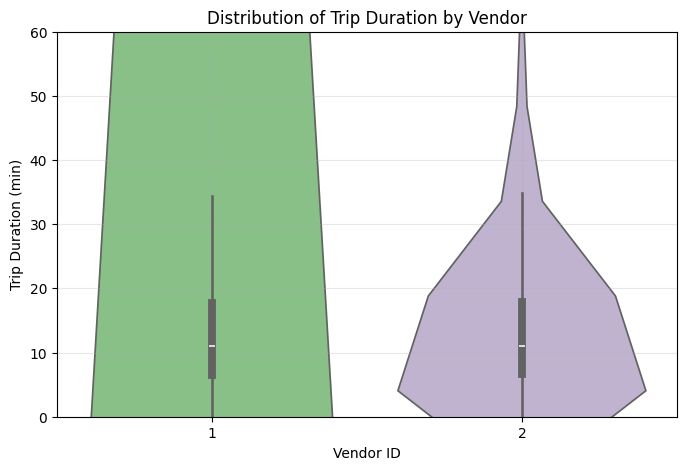

In [173]:
plt.figure(figsize=(8,5))
sns.violinplot(
    data=pdf,
    x="vendor_id",
    y="duration_min",
    palette="Accent"
)

plt.ylim(0, 60)
plt.title("Distribution of Trip Duration by Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-3981763539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


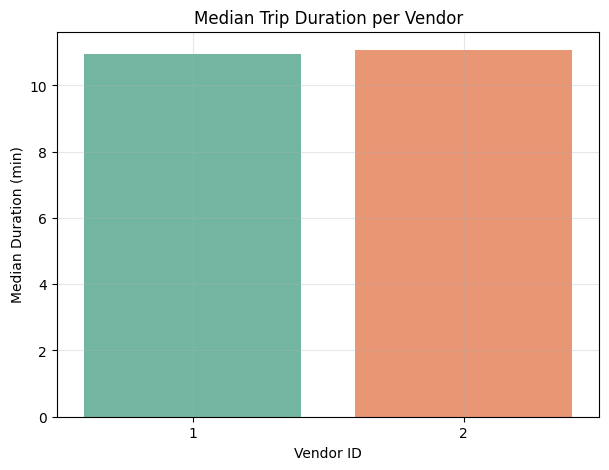

In [174]:
pdf_med = (
    pdf.groupby("vendor_id")["duration_min"]
       .median()
       .reset_index()
)

plt.figure(figsize=(7,5))
sns.barplot(
    data=pdf_med,
    x="vendor_id",
    y="duration_min",
    palette="Set2"
)

plt.title("Median Trip Duration per Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Median Duration (min)")
plt.grid(alpha=0.3)
plt.show()


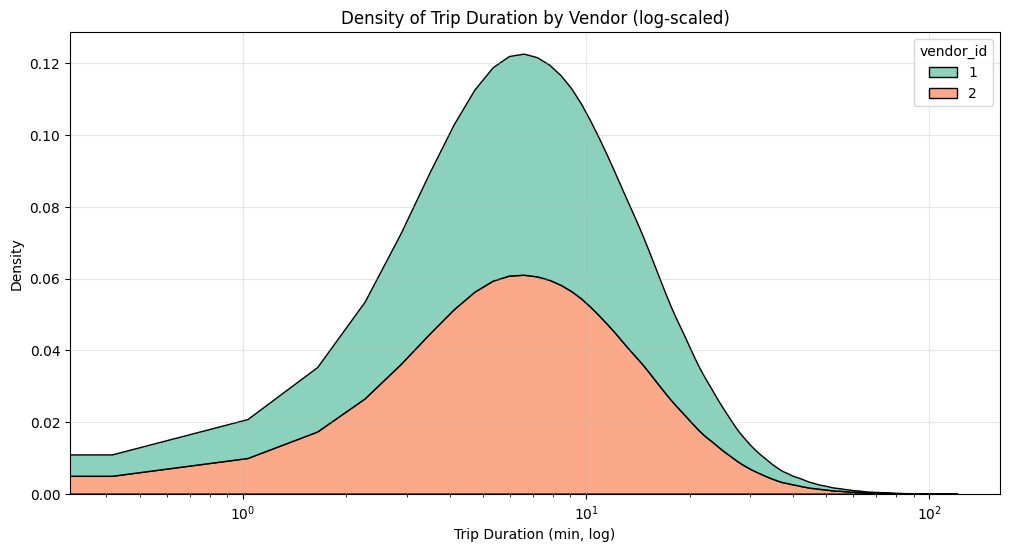

In [176]:
pdf_filtered = pdf[(pdf["duration_min"] > 0.1) & (pdf["duration_min"] < 120)]

plt.figure(figsize=(12,6))
sns.kdeplot(
    data=pdf_filtered,
    x="duration_min",
    hue="vendor_id",
    fill=True,
    common_norm=False,
    multiple="stack",
    palette="Set2"
)

plt.xscale("log")
plt.xlabel("Trip Duration (min, log)")
plt.title("Density of Trip Duration by Vendor (log-scaled)")
plt.grid(alpha=0.3)
plt.show()



In [177]:
pdf_small = data_trip.select(
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
).sample(False, 0.002).toPandas()  # sample to avoid 700k points


In [179]:
import folium

# Use a small sample so the map stays responsive
pdf_small = data_trip.select(
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
).sample(False, 0.002).toPandas()

# Center map around NYC
center_lat = pdf_small["pickup_latitude"].mean()
center_lon = pdf_small["pickup_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# --- PLOT PICKUPS (RED) ---
for _, row in pdf_small.iterrows():
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=2.5,
        color="red",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# --- PLOT DROPOFFS (GREEN) ---
for _, row in pdf_small.iterrows():
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=2.5,
        color="green",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m   # <-- VERY IMPORTANT: leave this as the last line to show the map inline


In [181]:
import folium
import pyspark.sql.functions as F

# ----- SAMPLE ONLY 20 TRIPS -----
pdf_20 = (
    data_trip
    .select(
        "pickup_latitude", "pickup_longitude",
        "dropoff_latitude", "dropoff_longitude"
    )
    .dropna()
    .sample(False, 200 / data_trip.count())   # approximate sample of 20 rows
    .toPandas()
).head(200)   # ensure exactly 20

# ----- CENTER MAP AROUND THE 20 PICKUPS -----
center_lat = pdf_20["pickup_latitude"].mean()
center_lon = pdf_20["pickup_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# ----- PLOT EACH TRIP -----
for _, row in pdf_20.iterrows():

    # pickup marker (red)
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

    # dropoff marker (green)
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=4,
        color="green",
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

    # line connecting pickup -> dropoff
    folium.PolyLine(
        locations=[
            [row["pickup_latitude"], row["pickup_longitude"]],
            [row["dropoff_latitude"], row["dropoff_longitude"]],
        ],
        color="blue",
        weight=2,
        opacity=0.7
    ).add_to(m)

m   # <-- important to display inline


In [182]:
import pyspark.sql.functions as F

# Ensure hour and weekday columns exist
data_trip = (
    data_trip
    .withColumn("pickup_hour", F.hour("pickup_datetime"))
    .withColumn("weekday", F.date_format("pickup_datetime", "EEEE"))  # "Monday", "Tuesday", etc.
)

# Convert only the needed columns (avoid pulling full dataset)
pdf_rides = data_trip.select(
    "pickup_latitude", "pickup_longitude",
    "pickup_hour", "weekday"
).sample(False, 0.1).toPandas()   # 10% sample for speed


In [183]:
import numpy as np
import matplotlib.pyplot as plt

def heat_map(ax_id, title, df, nsew):
    """
    ax_id : subplot ID (e.g., 131, 132, 133)
    title : string for subplot
    df    : pandas subset containing rides from a specific hour
    nsew  : [north, south, east, west] bounding box
    """
    ax = plt.subplot(ax_id)

    # bounding box
    north, south, east, west = nsew

    # bin grid
    bins_x = np.linspace(west, east, 200)
    bins_y = np.linspace(south, north, 200)

    # create heatmap
    heatmap, xedges, yedges = np.histogram2d(
        df["pickup_latitude"],
        df["pickup_longitude"],
        bins=[bins_y, bins_x]
    )

    ax.imshow(
        heatmap.T,
        extent=[south, north, west, east],
        origin='lower',
        cmap="hot",
        alpha=0.85,
        aspect="auto"
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.grid(False)


In [184]:
target_day = "Thursday"

# bounding box [north, south, east, west]
nsew = [40.9, 40.6, -73.7, -74.1]

hrs = [8, 17, 23]               # morning, evening rush, late night
titles = ["8 AM", "5 PM", "11 PM"]
subplot_ids = [131, 132, 133]


In [187]:
!pip install contextily
!pip install geopandas
!pip install shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 22.3 MB/s eta 0:00:00


In [188]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# take a SMALL sample so it renders like your example
pdf_small = (
    data_trip
        .select("pickup_latitude", "pickup_longitude", "pickup_hour")
        .filter((F.col("pickup_latitude") > 40.5) & (F.col("pickup_latitude") < 41))
        .sample(False, 0.01)    # ~1% sample
        .toPandas()
)

# convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    pdf_small,
    geometry=gpd.points_from_xy(pdf_small.pickup_longitude, pdf_small.pickup_latitude),
    crs="EPSG:4326"
).to_crs("EPSG:3857")   # convert to Web-Mercator for map tiles


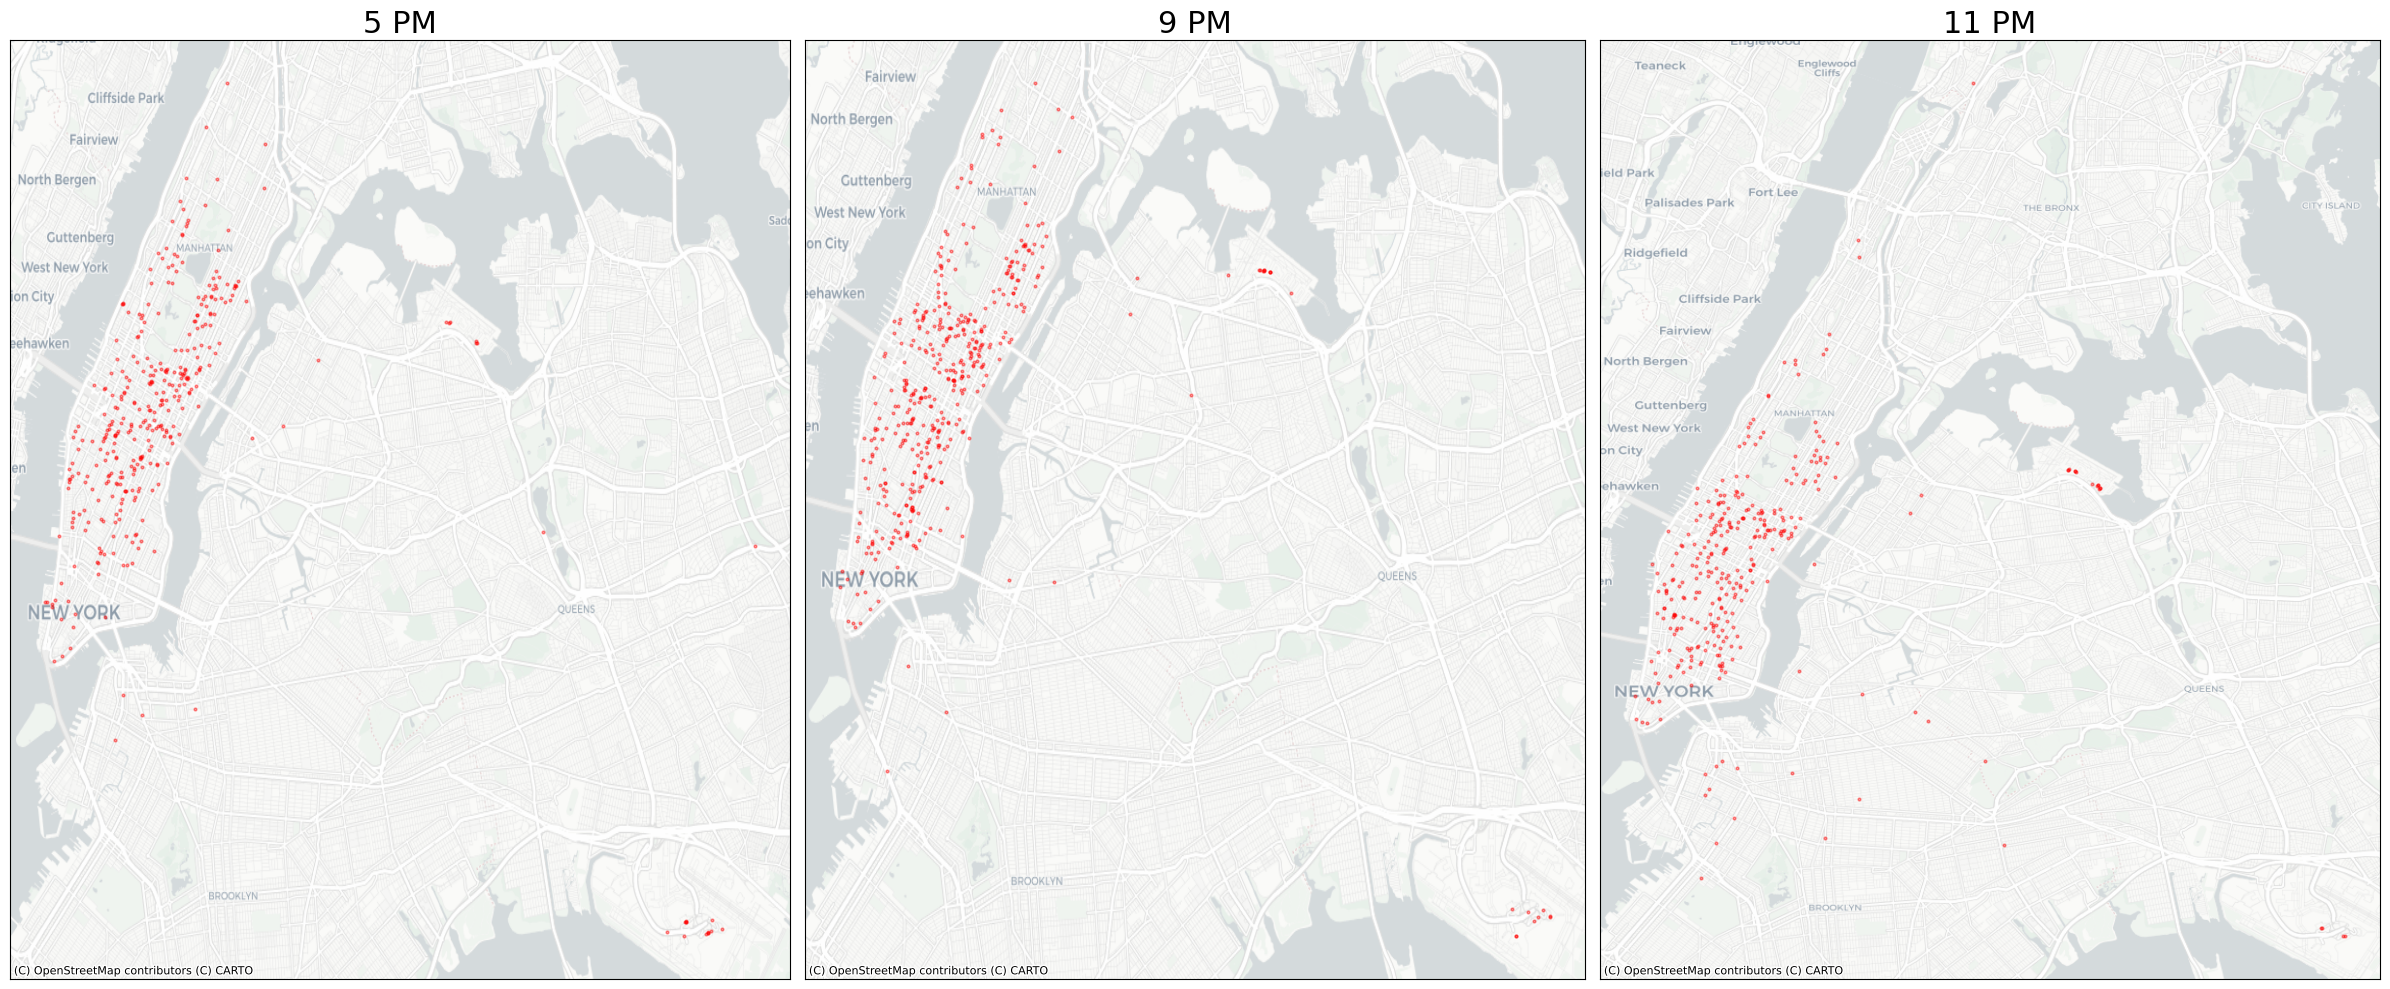

In [190]:
peak_hours = [17, 21, 23]
titles = ["5 PM", "9 PM", "11 PM"]

fig, axes = plt.subplots(1, 3, figsize=(24, 10))

for ax, hour, title in zip(axes, peak_hours, titles):
    gdf_hour = gdf[gdf['pickup_hour'] == hour]

    # scatter with density vibe
    ax.scatter(
        gdf_hour.geometry.x,
        gdf_hour.geometry.y,
        s=4,
        c="red",
        alpha=0.4
    )

    # basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,    # grey simplified map – similar to your image
        zoom=12
    )

    ax.set_title(title, fontsize=22)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
